In [162]:
# Load Packages
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from math import sqrt

# Load Tweets
rf = pd.read_csv("rf.csv", lineterminator='\n')
actual_ret = pd.read_csv("actual_ret.csv")
lr_pred = pd.read_csv("lr_pred.csv") 
rf_pred = pd.read_csv("rf_pred.csv")
gbrt_pred = pd.read_csv("gbrt_pred.csv")
nn_pred = pd.read_csv("nn2_pred.csv") 

pred = [lr_pred, rf_pred, gbrt_pred, nn_pred]

In [170]:
# Create Functions for Evaluation
def mse(actual_ret, pred_ret):
    d = (actual_ret - pred_ret)**2
    mse = sum(d) / len(d)
    return mse


def mae(actual_ret, pred_ret):
    d = (actual_ret - pred_ret)
    mae = sum(abs(d)) / len(d)
    return mae
    
def rmse(actual_ret, pred_ret):
    d = (actual_ret - pred_ret)**2
    mse = sum(d) / len(d)
    rmse = sqrt(mse)
    return rmse

def r_sq(actual_ret, pred_ret):
    nom = sum((actual_ret - pred_ret)**2)
    denom = sum(actual_ret**2) # Note that R2 is demeaned
    r_sq = (1 - (nom / denom)) * 100
    return r_sq

# Calculate the percentage of correct sign predictions
def hr(actual_ret, pred_ret):
    num_correct = sum((pred > 0) == (actual > 0) for pred, actual in zip(pred_ret, actual_ret))
    hr = (num_correct / len(pred_ret)) * 100
    return hr

In [164]:
# Percentages to actual returns, note that before we multiplied by 100
actual_ret['ret+1'] = actual_ret['ret+1'] 

# Divide every dataframe of predictions by 100 to get 
#for p in pred:
#    p /= 100

# Merge risk-free rate and actual return by 'date'
df = pd.merge(actual_ret, rf, on = 'date')

for i in range(len(pred)):
    pred[i] = pd.concat([df, pred[i]], axis=1)

# Convert list of df back to seperate df
lr_pred, rf_pred, gbrt_pred, nn_pred = pred

# Specifies Companies
company = ["AAPL", "ADBE", "AMD", "AMZN", "ASML",
           "AVGO", "AZN", "CMCSA", "COST", "CSCO",
           "GOOG", "META", "MSFT", "NFLX", "NVDA",
           "PCAR", "PEP", "TMUS", "TSLA", "TXN"]

In [174]:
# Calculates the R2 for each company, each model, and each algorithm
def company_results(data):
    results = []
    
    for c in company:
        for i in range(0, 4):
            actual_y = actual_ret[actual_ret['company'] == c]
            pred_y = data[data['company'] == c]
            r2 = round(r_sq(actual_y['ret+1'], pred_y[str(i)]), 2)
            results.append([c, i, r2])
    df = pd.DataFrame(results, columns=['c', 'i', 'r2'])
    df = pd.pivot_table(df, index='c', columns='i', values='r2')
    
    return df

#company_results(lr_pred)
#company_results(rf_pred)
#company_results(gbrt_pred)
#company_results(nn_pred)

In [172]:
# Calculates the MSE for each company, each model, and each algorithm
def company_results(data):
    results = []
    
    for c in company:
        for i in range(0, 4):
            actual_y = actual_ret[actual_ret['company'] == c]
            pred_y = data[data['company'] == c]
            sc = round(rmse(actual_y['ret+1'], pred_y[str(i)]), 2)
            results.append([c, i, sc])
    df = pd.DataFrame(results, columns=['c', 'i', 'sc'])
    df = pd.pivot_table(df, index='c', columns='i', values='sc')
    
    return df

#company_results(lr_pred)
#company_results(rf_pred)
#company_results(gbrt_pred)
#company_results(nn_pred)

In [173]:
# Calculates the HR for each company, each model, and each algorithm
def company_results(data):
    results = []
    
    for c in company:
        for i in range(0, 4):
            actual_y = actual_ret[actual_ret['company'] == c]
            pred_y = data[data['company'] == c]
            sc = round(hr(actual_y['ret+1'], pred_y[str(i)]), 2)
            results.append([c, i, sc])
    df = pd.DataFrame(results, columns=['c', 'i', 'sc'])
    df = pd.pivot_table(df, index='c', columns='i', values='sc')
    
    return df

#company_results(lr_pred)
#company_results(rf_pred)
#company_results(gbrt_pred)
#company_results(nn_pred)

In [179]:
# Long Strategy
def long_strategy(df):
    
    list_dict = {}
    for i in range(0, 4):
        long_ret = []
        for index, row in df.iterrows():
            if row[str(i)] > row['rf']:
                long_ret.append(row['ret+1'])
            else:
                long_ret.append(row['rf'])
        list_dict[str(i)] = long_ret
    results = pd.DataFrame(list_dict)
    return results

# Long Strategy in Table
def table_long_strategy(df):
    store_company = []
    store_model = []
    store_total = []

    for c in company:
        x = df[df['company'] == c]
        x = long_strategy(x)
        for i in range(0, 4):
            total = round(sum(x[str(i)]), 1)
            store_company.append(c)
            store_model.append(i)
            store_total.append(total)

    long_strategy_results = pd.DataFrame({'company': store_company, 'model': store_model, 'total': store_total})
    long_strategy_results = pd.pivot_table(long_strategy_results, index='company', columns='model', values='total')
    long_strategy_results['Buy Hold'] = round(actual_ret.groupby('company')['ret+1'].sum(), 1)
    return long_strategy_results

#table_long_short_strategy(lr_pred)
#table_long_short_strategy(rf_pred)
#table_long_short_strategy(gbrt_pred)
#table_long_short_strategy(nn_pred)

In [178]:
# Long-Short Strategy
def long_short_strategy(df):
    
    list_dict = {}
    for i in range(0, 4):
        long_short_ret = []
        for index, row in df.iterrows():
            if row[str(i)] > 0:
                long_short_ret.append(row['ret+1'])
            else:
                long_short_ret.append(-1 * row['ret+1'])
        list_dict[str(i)] = long_short_ret
    results = pd.DataFrame(list_dict)
    return results

# Long-Short Strategy in Table
def table_long_short_strategy(df):
    store_company = []
    store_model = []
    store_total = []

    for c in company:
        x = df[df['company'] == c]
        x = long_short_strategy(x)
        for i in range(0, 4):
            total = round(sum(x[str(i)]), 0)
            store_company.append(c)
            store_model.append(i)
            store_total.append(total)

    long_strategy_results = pd.DataFrame({'company': store_company, 'model': store_model, 'total': store_total})
    long_strategy_results = pd.pivot_table(long_strategy_results, index='company', columns='model', values='total')
    long_strategy_results['Buy Hold'] = round(actual_ret.groupby('company')['ret+1'].sum(), 1)
    return long_strategy_results

#table_long_short_strategy(lr_pred)
#table_long_short_strategy(rf_pred)
#table_long_short_strategy(gbrt_pred)
#table_long_short_strategy(nn_pred)

In [106]:
# Long-Short Portfolio
def cum_long(df):
    list_dict = {}
    for i in range(0, 4):
        cumulative_sum = 0
        list_name = "Model " + str(i)
        list_dict[list_name] = []
        for index, row in df.iterrows():
            if row[str(i)] > 0:
                cumulative_sum += row['ret+1']
            else:
                cumulative_sum += (row['rf'])
            list_dict[list_name].append(cumulative_sum)
    result = pd.DataFrame(list_dict)
    return result

# Long-Short Portfolio
def cum_long_short(df):
    list_dict = {}
    for i in range(0, 4):
        cumulative_sum = 0
        list_name = "Model " + str(i)
        list_dict[list_name] = []
        for index, row in df.iterrows():
            if row[str(i)] > 0:
                cumulative_sum += row['ret+1']
            else:
                cumulative_sum += (-1 * row['ret+1'])
            list_dict[list_name].append(cumulative_sum)
    result = pd.DataFrame(list_dict)
    return result

In [184]:
def long_graph(pred, method, company):
    ## Buy & Hold Stock for AAPL
    buy_hold = actual_ret.groupby('company').apply(lambda x: x.assign(sum_ret = x['ret+1'].cumsum()))
    buy_hold = buy_hold[buy_hold['company'] == company]
    
    # Set-up Data
    df = pred[pred['company'] == company]
    x = cum_long(df)
    x['date'] = buy_hold['date'].values
    x['Buy-Hold'] = buy_hold['sum_ret'].values

    # Plot & Save Graph
    x.plot(x = 'date', y = ['Buy-Hold', 'Model 0', 'Model 1', 'Model 2', 'Model 3'])
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(10, 5)  # Set the width to 8 inches and height to 6 inches
    plt.title("Cumulative Stock Return of Long Strategy for " + company + " using " + method + " Predictions")
    plt.xlabel("Date")
    plt.ylabel("Stock Return in Percentages")
    return plt

#long_graph(lr_pred, "LR", "AAPL")
#plt.savefig('Long_LR.jpg', dpi=300)

#long_graph(rf_pred, "RF", "AAPL")
#plt.savefig('Long_RF.jpg', dpi=300)

#long_graph(gbrt_pred, "GBRT", "AAPL")
#plt.savefig('Long_GBRT.jpg', dpi=300)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

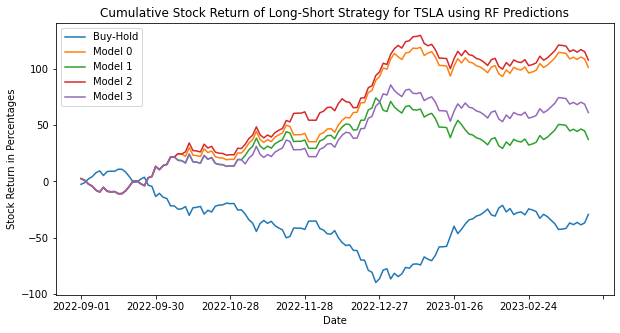

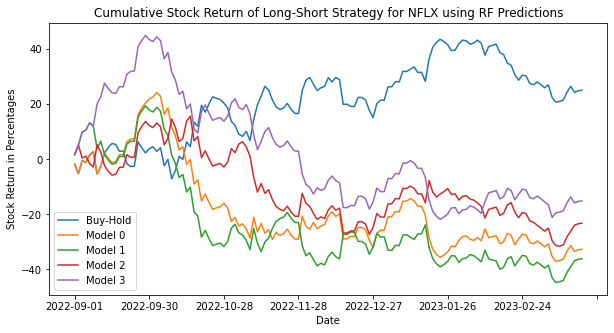

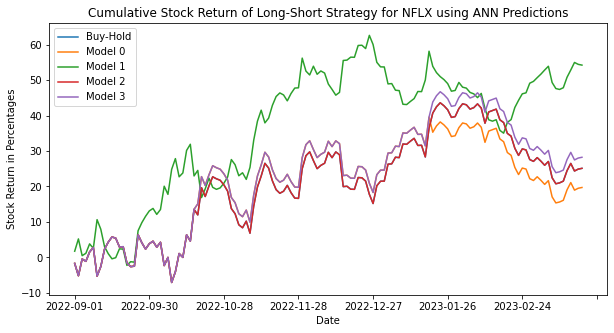

In [211]:
def long_short_graph(pred, method, company):
    ## Buy & Hold Stock for AAPL
    buy_hold = actual_ret.groupby('company').apply(lambda x: x.assign(sum_ret = x['ret+1'].cumsum()))
    buy_hold = buy_hold[buy_hold['company'] == company]

    # Set-up Data
    df = pred[pred['company'] == company]
    x = cum_long_short(df)
    x['date'] = buy_hold['date'].values
    x['Buy-Hold'] = buy_hold['sum_ret'].values

    # Plot & Save Graph
    x.plot(x = 'date', y = ['Buy-Hold', 'Model 0', 'Model 1', 'Model 2', 'Model 3'])
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(10, 5)  # Set the width to 8 inches and height to 6 inches
    plt.title("Cumulative Stock Return of Long-Short Strategy for " + company + " using " + method + " Predictions")
    plt.xlabel("Date")
    plt.ylabel("Stock Return in Percentages")
    return plt

long_short_graph(rf_pred, "RF", "TSLA")
#plt.savefig('TSLA.jpg', dpi=300)

long_short_graph(rf_pred, "RF", "NFLX")
#plt.savefig('NFLX.jpg', dpi=300)

long_short_graph(nn_pred, "ANN", "NFLX")
#plt.savefig('NFLX2.jpg', dpi=300)